# Инициализация

In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import keras
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Pave_\AppData\Local\Temp\ipykernel_16108\1803758516.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


In [2]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50
#Число классов
num_classes = 6

# Загрузка тренировочных данных

In [3]:
train = pd.read_csv('toxicCommentsDataSet/toxicCommentsTrain.csv')

In [4]:
#Получение комментариев
comments = train['comment_text']

In [5]:
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Токенизация

In [6]:
tokenizer = Tokenizer(num_words=num_words)

In [7]:
#Обучение токенайзера
tokenizer.fit_on_texts(comments)

In [8]:
train_sequences = tokenizer.texts_to_sequences(comments)

In [9]:
x_train = pad_sequences(train_sequences, maxlen=max_comment_len)

# Загрузка тестовых данных

In [10]:
test_comments = pd.read_csv('toxicCommentsDataSet/toxicCommentsTest.csv')

In [11]:
test_labels = pd.read_csv('toxicCommentsDataSet/toxicCommentsTestLabels.csv')

In [12]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [13]:
test = test_full[test_full['toxic']!=-1]

# Токенизация

In [14]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

In [15]:
y_test = test[['toxic',	'severe_toxic',	'obscene', 'threat',	'insult',	'identity_hate']]

In [16]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

# Проверка лучшей модели

In [17]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=68, input_length=max_comment_len,
                    embeddings_regularizer=keras.regularizers.l2(0.001)))
model.add(SimpleRNN(units=36, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True))
model.add(SimpleRNN(units=36, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001),return_sequences=True ))
model.add(SimpleRNN(units=36, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 68)            680000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 36)            3780      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 36)            2628      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 36)                2628      
                                                                 
 dense (Dense)               (None, 6)                 222       
                                                                 
Total params: 689,258
Trainable params: 689,258
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_model = model.fit(x_train,
                          y_train,
                          epochs=5,
                          batch_size=1024,
                          validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 282s 2s/step - loss: 0.3408 - auc: 0.7701 - accuracy: 0.8105 - val_loss: 0.1443 - val_auc: 0.9404 - val_accuracy: 0.9904
Epoch 2/5
125/125 [==============================] - 288s 2s/step - loss: 0.1256 - auc: 0.9484 - accuracy: 0.9939 - val_loss: 0.1123 - val_auc: 0.9543 - val_accuracy: 0.9941
Epoch 3/5
125/125 [==============================] - 262s 2s/step - loss: 0.1066 - auc: 0.9550 - accuracy: 0.9942 - val_loss: 0.1011 - val_auc: 0.9590 - val_accuracy: 0.9941
Epoch 4/5
125/125 [==============================] - 287s 2s/step - loss: 0.0996 - auc: 0.9565 - accuracy: 0.9942 - val_loss: 0.0970 - val_auc: 0.9593 - val_accuracy: 0.9941
Epoch 5/5
125/125 [==============================] - 290s 2s/step - loss: 0.0935 - auc: 0.9600 - accuracy: 0.9942 - val_loss: 0.0918 - val_auc: 0.9601 - val_accuracy: 0.9941


In [25]:
model.evaluate(x_test, y_test)

2000/2000 [==============================] - 28s 14ms/step - loss: 0.1079 - auc: 0.9508 - accuracy: 0.9976


[0.10794690996408463, 0.9507681727409363, 0.9976085424423218]

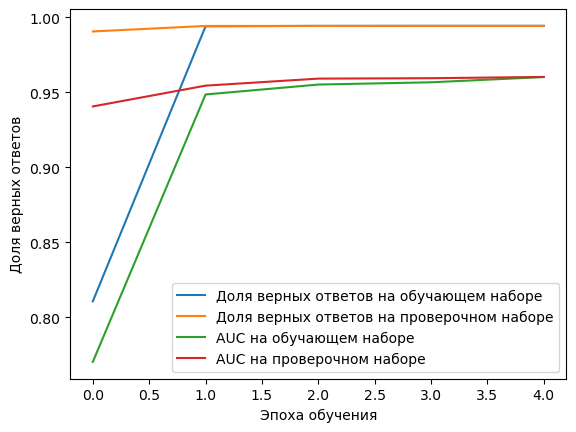

In [22]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.plot(history_model.history['auc'],
         label='AUC на обучающем наборе')
plt.plot(history_model.history['val_auc'],
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

2000/2000 [==============================] - 26s 13ms/step - loss: 0.1079 - auc: 0.9508 - accuracy: 0.9976


[0.10794690996408463, 0.9507681727409363, 0.9976085424423218]

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.